# Multimodal RAG System - Data Extraction & Preprocessing

This notebook handles:
- PDF parsing and text extraction
- Image extraction from PDFs
- OCR on extracted images
- Text chunking with metadata
- Data preprocessing and storage


## 1. Install Required Libraries


In [ ]:
# Uncomment and run this cell to install required packages
# !pip install pymupdf pdfplumber Pillow pytesseract pdf2image opencv-python numpy pandas
# !pip install sentence-transformers transformers torch
# !pip install langchain langchain-community

# Note: For Windows, you'll need to install Tesseract OCR separately:
# Download from: https://github.com/UB-Mannheim/tesseract/wiki
# And poppler for pdf2image:
# Download from: https://github.com/oschwartz10612/poppler-windows/releases


## 2. Import Libraries


In [4]:
# UPDATE CONFIGURATION: Add separate folder for rendered pages
RENDERED_PAGES_FOLDER = os.path.join(OUTPUT_FOLDER, "rendered_pages")
IMAGES_FOLDER = os.path.join(OUTPUT_FOLDER, "charts")  # Rename: only extracted charts

os.makedirs(RENDERED_PAGES_FOLDER, exist_ok=True)
os.makedirs(IMAGES_FOLDER, exist_ok=True)

print("✓ Updated configuration:")
print(f"  - Rendered pages will be saved to: {RENDERED_PAGES_FOLDER}")
print(f"  - Extracted charts will be saved to: {IMAGES_FOLDER}")


✓ Updated configuration:
  - Rendered pages will be saved to: extracted_data\rendered_pages
  - Extracted charts will be saved to: extracted_data\charts


In [1]:
import fitz  # PyMuPDF
import pdfplumber
from PIL import Image
import pytesseract
import cv2
import numpy as np
import pandas as pd
import json
import os
import re
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import Counter
import io
import pickle
from datetime import datetime

# Set Tesseract path for Windows (update this path based on your installation)
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

print("Libraries imported successfully!")


Libraries imported successfully!


## 3. Configuration and Setup


In [3]:
# Configuration
DATA_FOLDER = "Data"
OUTPUT_FOLDER = "extracted_data"
IMAGES_FOLDER = os.path.join(OUTPUT_FOLDER, "images")
TEXT_FOLDER = os.path.join(OUTPUT_FOLDER, "text_chunks")
METADATA_FOLDER = os.path.join(OUTPUT_FOLDER, "metadata")
TABLES_FOLDER = os.path.join(OUTPUT_FOLDER, "tables")

# Create output directories
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(IMAGES_FOLDER, exist_ok=True)
os.makedirs(TEXT_FOLDER, exist_ok=True)
os.makedirs(METADATA_FOLDER, exist_ok=True)
os.makedirs(TABLES_FOLDER, exist_ok=True)

# Text chunking parameters (WORD-BASED)
CHUNK_SIZE_WORDS = 120  # words per chunk (~600 tokens)
CHUNK_OVERLAP_WORDS = 25  # word overlap between chunks 

print(f"Output directories created at: {OUTPUT_FOLDER}")
print(f"Chunking configuration: {CHUNK_SIZE_WORDS} words/chunk, {CHUNK_OVERLAP_WORDS} words overlap")


Output directories created at: extracted_data
Chunking configuration: 120 words/chunk, 25 words overlap


In [5]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

## 4. Text Cleaning Functions


In [6]:
def remove_page_numbers(text: str) -> str:
    """Remove common page number patterns."""
    patterns = [
        r'Page\s+\d+\s+of\s+\d+',
        r'page\s+\d+\s+of\s+\d+',
        r'\bp\.\s*\d+\b',
        r'^\s*\d+\s*$',  # Standalone numbers on a line
        r'\[\s*\d+\s*\]',  # [1], [2], etc.
        r'^\s*-\s*\d+\s*-\s*$',  # - 5 - style page numbers
    ]
    
    for pattern in patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.MULTILINE)
    
    return text


def fix_hyphenated_words(text: str) -> str:
    """Fix words split across lines with hyphens."""
    # Match word-\nword or word-\rword patterns
    text = re.sub(r'(\w+)-\s*[\n\r]+\s*(\w+)', r'\1\2', text)
    return text


def remove_table_of_contents(text: str) -> str:
    """Remove table of contents sections."""
    # Look for common TOC patterns
    toc_patterns = [
        r'(?i)table\s+of\s+contents.*?(?=\n\n|\n[A-Z])',
        r'(?i)contents\s*\n.*?(?=\n\n\n)',
    ]
    
    for pattern in toc_patterns:
        text = re.sub(pattern, '', text, flags=re.DOTALL)
    
    return text


def detect_repeated_text(pages: List[str], threshold: int = 3) -> List[str]:
    """
    Detect headers/footers by finding text that appears on multiple pages.
    Returns list of repeated text snippets to remove.
    """
    # Get first and last 2 lines from each page
    repeated_candidates = []
    
    for page in pages:
        lines = page.split('\n')
        if len(lines) >= 2:
            repeated_candidates.append(lines[0].strip())  # First line (header)
            repeated_candidates.append(lines[-1].strip())  # Last line (footer)
    
    # Count occurrences
    counter = Counter(repeated_candidates)
    
    # Return text that appears on multiple pages (likely headers/footers)
    repeated = [text for text, count in counter.items() 
                if count >= threshold and len(text) > 5 and len(text) < 200]
    
    return repeated


def clean_text(text: str, repeated_text: List[str] = None) -> str:
    """
    Apply all text cleaning operations.
    
    Args:
        text: Raw text to clean
        repeated_text: List of repeated headers/footers to remove
    
    Returns:
        Cleaned text
    """
    # Fix hyphenated words first
    text = fix_hyphenated_words(text)
    
    # Remove page numbers
    text = remove_page_numbers(text)
    
    # Remove table of contents
    text = remove_table_of_contents(text)
    
    # Remove repeated headers/footers
    if repeated_text:
        for repeated in repeated_text:
            if repeated:
                text = text.replace(repeated, '')
    
    # Clean up extra whitespace
    text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)  # Multiple newlines to double
    text = re.sub(r' +', ' ', text)  # Multiple spaces to single
    
    return text.strip()


## 9b. UPDATED Chart Extraction (Filters Out Text-Only Regions)


In [7]:
def is_chart_region(region: np.ndarray) -> bool:
    """
    Determine if a region contains a chart/graph vs just text paragraphs.
    
    Args:
        region: Image region as numpy array
        
    Returns:
        True if region appears to be a chart/graph, False if it's text-only
    """
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region
    h, w = gray.shape
    
    # 1. Edge detection
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / (w * h)
    
    # 2. Check for horizontal line patterns (typical of text)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (w // 10, 1))
    horizontal_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, horizontal_kernel)
    horizontal_density = np.sum(horizontal_edges > 0) / (w * h)
    
    # 3. Check edge distribution variance (charts have varied patterns, text is uniform)
    rows_per_section = max(1, h // 10)
    row_densities = []
    for i in range(0, h, rows_per_section):
        section = edges[i:i+rows_per_section, :]
        if section.size > 0:
            row_densities.append(np.sum(section > 0) / section.size)
    edge_variance = np.var(row_densities) if len(row_densities) > 0 else 0
    
    # 4. Check for shapes/contours (charts have distinct shapes)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    shape_count = len([c for c in contours if cv2.contourArea(c) > 100])
    
    # Decision logic:
    # - Text-only regions: high horizontal density, low variance, few shapes
    # - Chart regions: varied edge patterns, distinct shapes, higher variance
    
    is_text_only = (
        horizontal_density > 0.15 and  # Strong horizontal patterns (text lines)
        edge_variance < 0.001 and      # Very uniform (text rows)
        shape_count < 5                 # Few distinct shapes
    )
    
    is_likely_chart = (
        edge_density > 0.08 or         # Sufficient complexity
        shape_count >= 5 or             # Multiple shapes/elements
        edge_variance > 0.002           # Varied patterns
    )
    
    return is_likely_chart and not is_text_only


def extract_chart_regions_v2(page_image_path: str, page_num: int, source_file: str, 
                              charts_folder: str) -> List[Dict]:
    """
    UPDATED: Extract only CHART/GRAPH regions, filtering out text-only areas.
    Saves rendered pages separately from extracted charts.
    
    Args:
        page_image_path: Path to rendered page image
        page_num: Page number
        source_file: Source PDF filename
        charts_folder: Folder to save extracted CHARTS (not the rendered page)
        
    Returns:
        List of extracted chart regions with metadata
    """
    img = cv2.imread(page_image_path)
    if img is None:
        return []
    
    height, width = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use edge detection to find regions
    edges = cv2.Canny(gray, 50, 150)
    
    # Dilate to connect nearby edges
    kernel = np.ones((15, 15), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    chart_regions = []
    base_filename = Path(source_file).stem
    chart_counter = 0
    skipped_text_regions = 0
    
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter by size - must be substantial region
        min_width, min_height = width * 0.15, height * 0.1  # At least 15% width, 10% height
        max_width, max_height = width * 0.95, height * 0.9   # Not whole page
        
        if not (w >= min_width and h >= min_height and 
                w <= max_width and h <= max_height and
                w >= 200 and h >= 150):  # Absolute minimum pixels
            continue
        
        # Extract region
        padding = 20
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(width, x + w + padding)
        y2 = min(height, y + h + padding)
        
        region = img[y1:y2, x1:x2]
        
        # FILTER: Check if this is actually a chart (not just text)
        if not is_chart_region(region):
            skipped_text_regions += 1
            continue  # Skip text-only regions
        
        chart_counter += 1
        
        # Save chart region to CHARTS folder
        region_filename = f"{base_filename}_page{page_num}_chart{chart_counter}.png"
        region_path = os.path.join(charts_folder, region_filename)
        cv2.imwrite(region_path, region)
        
        chart_regions.append({
            'image_path': region_path,
            'page_number': page_num,
            'source_file': source_file,
            'content_type': 'image',
            'image_index': chart_counter,
            'extraction_method': 'rendered_page',
            'bbox': {'x': x1, 'y': y1, 'width': x2-x1, 'height': y2-y1},
            'extraction_time': datetime.now().isoformat()
        })
    
    if skipped_text_regions > 0:
        print(f"  Page {page_num}: Found {chart_counter} charts, skipped {skipped_text_regions} text-only regions")
    
    return chart_regions


In [8]:
def extract_financial_figures(text: str) -> Dict[str, List[str]]:
    """
    Extract financial figures and metrics from text.
    
    Returns:
        Dictionary with categorized financial figures
    """
    figures = {
        'currency': [],
        'percentages': [],
        'large_numbers': [],
        'ratios': []
    }
    
    # Currency patterns: $X.XXM, $X,XXX, $XXX.XX, etc.
    currency_patterns = [
        r'\$\s*\d+(?:,\d{3})*(?:\.\d+)?(?:\s*[BMK])?(?:illion)?',  # $1.5M, $1,000,000
        r'USD?\s*\d+(?:,\d{3})*(?:\.\d+)?(?:\s*[BMK])?',  # USD 1.5M
        r'₹\s*\d+(?:,\d{2,3})*(?:\.\d+)?(?:\s*[CLK]r?)?',  # Indian Rupees
        r'€\s*\d+(?:,\d{3})*(?:\.\d+)?(?:\s*[BMK])?',  # Euros
    ]
    
    for pattern in currency_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        figures['currency'].extend(matches)
    
    # Percentage patterns: XX%, X.X%
    percentage_pattern = r'\d+(?:\.\d+)?%'
    figures['percentages'] = re.findall(percentage_pattern, text)
    
    # Large numbers with commas: 1,000,000
    large_number_pattern = r'\b\d{1,3}(?:,\d{3})+\b'
    figures['large_numbers'] = re.findall(large_number_pattern, text)
    
    # Ratios: X:Y, X to Y
    ratio_pattern = r'\b\d+(?:\.\d+)?(?:\s*:\s*|\s+to\s+)\d+(?:\.\d+)?\b'
    figures['ratios'] = re.findall(ratio_pattern, text, re.IGNORECASE)
    
    return figures


def normalize_financial_value(value_str: str) -> Optional[float]:
    """
    Convert financial string to normalized numeric value.
    E.g., "$1.5M" -> 1500000.0
    """
    try:
        # Remove currency symbols and spaces
        value_str = re.sub(r'[$₹€£USD\s]', '', value_str, flags=re.IGNORECASE)
        
        # Handle magnitude suffixes
        multipliers = {
            'K': 1_000,
            'M': 1_000_000,
            'B': 1_000_000_000,
            'T': 1_000_000_000_000,
            'CR': 10_000_000,  # Crore
            'L': 100_000,  # Lakh
            'MILLION': 1_000_000,
            'BILLION': 1_000_000_000,
        }
        
        multiplier = 1
        for suffix, mult in multipliers.items():
            if suffix in value_str.upper():
                multiplier = mult
                value_str = re.sub(suffix, '', value_str, flags=re.IGNORECASE)
                break
        
        # Remove commas and convert
        value_str = value_str.replace(',', '')
        value = float(value_str) * multiplier
        
        return value
    except:
        return None


## 6. Table Detection and Extraction


In [9]:
def extract_tables_from_pdf(pdf_path: str) -> List[Dict]:
    """
    Extract tables from PDF using pdfplumber.
    
    Returns:
        List of dictionaries containing table data and metadata
    """
    tables_data = []
    
    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages, 1):
            # Extract tables from page
            tables = page.extract_tables()
            
            for table_idx, table in enumerate(tables, 1):
                if not table or len(table) < 2:  # Skip empty or single-row tables
                    continue
                
                # Convert table to readable format
                table_text = format_table_as_text(table)
                
                # Convert to DataFrame for easier processing
                try:
                    df = pd.DataFrame(table[1:], columns=table[0])
                    df_dict = df.to_dict('records')
                except:
                    df_dict = None
                
                tables_data.append({
                    'table_id': f"{Path(pdf_path).stem}_table_{page_num}_{table_idx}",
                    'page_number': page_num,
                    'source_file': os.path.basename(pdf_path),
                    'content_type': 'table',
                    'table_text': table_text,
                    'num_rows': len(table),
                    'num_cols': len(table[0]) if table else 0,
                    'raw_data': table,
                    'structured_data': df_dict,
                    'extraction_time': datetime.now().isoformat()
                })
    
    print(f"Extracted {len(tables_data)} tables from {os.path.basename(pdf_path)}")
    return tables_data


def format_table_as_text(table: List[List[str]]) -> str:
    """
    Convert table to pipe-separated text format.
    
    Args:
        table: List of rows, each row is a list of cells
    
    Returns:
        Formatted table as text
    """
    if not table:
        return ""
    
    # Clean cells
    cleaned_table = []
    for row in table:
        cleaned_row = [str(cell).strip() if cell else "" for cell in row]
        cleaned_table.append(cleaned_row)
    
    # Format as pipe-separated
    formatted_rows = []
    for row in cleaned_table:
        formatted_rows.append(" | ".join(row))
    
    # Add separator after header
    if len(formatted_rows) > 1:
        col_widths = [len(cell) for cell in cleaned_table[0]]
        separator = " | ".join(["-" * max(width, 3) for width in col_widths])
        formatted_rows.insert(1, separator)
    
    return "\n".join(formatted_rows)


## 7. Word-Based Text Chunking


In [10]:
def chunk_text_by_words(text: str, chunk_size_words: int = 60, 
                        overlap_words: int = 10) -> List[Dict]:
    """
    Split text into overlapping chunks based on WORD count.
    
    Args:
        text: Input text to chunk
        chunk_size_words: Number of words per chunk
        overlap_words: Number of overlapping words between chunks
        
    Returns:
        List of dictionaries with chunk text and metadata
    """
    if not text or not text.strip():
        return []
    
    # Split into words (preserving spaces for reconstruction)
    words = text.split()
    
    # Handle edge case: text shorter than chunk size
    if len(words) <= chunk_size_words:
        return [{
            'text': text,
            'word_count': len(words),
            'char_count': len(text),
            'chunk_index': 0,
            'is_complete': True
        }]
    
    chunks = []
    start_idx = 0
    chunk_idx = 0
    
    while start_idx < len(words):
        # Get chunk of words
        end_idx = min(start_idx + chunk_size_words, len(words))
        chunk_words = words[start_idx:end_idx]
        
        # Try to break at sentence boundary
        chunk_text = " ".join(chunk_words)
        
        # If not at the end, try to break at sentence boundary
        if end_idx < len(words):
            # Look for sentence endings in the last 20% of the chunk
            last_portion = chunk_text[int(len(chunk_text) * 0.8):]
            
            # Find last sentence ending
            sentence_endings = ['.', '!', '?', '\n']
            last_break = -1
            for ending in sentence_endings:
                pos = last_portion.rfind(ending)
                if pos > last_break:
                    last_break = pos
            
            # If found a good break point, use it
            if last_break > 0:
                break_point = int(len(chunk_text) * 0.8) + last_break + 1
                chunk_text = chunk_text[:break_point].strip()
                # Recalculate word count based on actual text
                actual_words = chunk_text.split()
                end_idx = start_idx + len(actual_words)
        
        chunks.append({
            'text': chunk_text.strip(),
            'word_count': len(chunk_text.split()),
            'char_count': len(chunk_text),
            'chunk_index': chunk_idx,
            'start_word_idx': start_idx,
            'end_word_idx': end_idx,
            'is_complete': end_idx >= len(words)
        })
        
        # Move to next chunk with overlap
        start_idx = end_idx - overlap_words
        if start_idx <= chunks[-1]['start_word_idx']:  # Prevent infinite loop
            start_idx = end_idx
        
        chunk_idx += 1
    
    return chunks


## 8. Enhanced PDF Text Extraction


In [11]:
def extract_text_from_pdf_enhanced(pdf_path: str) -> Tuple[List[str], List[Dict]]:
    """
    Extract text from PDF with cleaning and metadata.
    
    Returns:
        Tuple of (list of page texts, list of page metadata)
    """
    doc = fitz.open(pdf_path)
    pages_text = []
    pages_metadata = []
    
    # First pass: collect all page texts for header/footer detection
    for page_num in range(len(doc)):
        page = doc[page_num]
        text = page.get_text("text")
        pages_text.append(text)
    
    # Detect repeated headers/footers
    repeated_text = detect_repeated_text(pages_text)
    print(f"Detected {len(repeated_text)} repeated header/footer patterns")
    
    # Second pass: clean text and extract metadata
    cleaned_pages = []
    for page_num, text in enumerate(pages_text, 1):
        if not text.strip():
            continue
        
        # Clean the text
        cleaned = clean_text(text, repeated_text)
        
        if not cleaned:
            continue
        
        # Extract financial figures from page
        financial_figs = extract_financial_figures(cleaned)
        
        pages_metadata.append({
            'page_number': page_num,
            'source_file': os.path.basename(pdf_path),
            'raw_char_count': len(text),
            'cleaned_char_count': len(cleaned),
            'word_count': len(cleaned.split()),
            'financial_figures': financial_figs,
            'has_financial_data': any(financial_figs.values())
        })
        
        cleaned_pages.append(cleaned)
    
    doc.close()
    print(f"Extracted and cleaned text from {len(cleaned_pages)} pages of {os.path.basename(pdf_path)}")
    
    return cleaned_pages, pages_metadata


## 9. Image Extraction Functions


## 9a. PDF Page Rendering for Complete Charts


In [12]:
def render_pdf_pages_as_images(pdf_path: str, output_folder: str, dpi: int = 200) -> List[Dict]:
    """
    Render entire PDF pages as images to capture charts WITH labels.
    This captures the visual appearance including text labels overlaid on charts.
    
    Args:
        pdf_path: Path to PDF file
        output_folder: Folder to save rendered pages
        dpi: Resolution for rendering (higher = better quality but larger files)
        
    Returns:
        List of rendered page image paths with metadata
    """
    from pdf2image import convert_from_path
    
    print(f"Rendering pages from {os.path.basename(pdf_path)} at {dpi} DPI...")
    
    try:
        # Convert PDF pages to images
        images = convert_from_path(pdf_path, dpi=dpi)
        
        rendered_pages = []
        base_filename = Path(pdf_path).stem
        
        for page_num, img in enumerate(images, 1):
            # Save rendered page
            page_filename = f"{base_filename}_rendered_page{page_num}.png"
            page_path = os.path.join(output_folder, page_filename)
            img.save(page_path, 'PNG')
            
            rendered_pages.append({
                'page_path': page_path,
                'page_number': page_num,
                'source_file': os.path.basename(pdf_path),
                'width': img.width,
                'height': img.height,
                'dpi': dpi
            })
        
        print(f"  Rendered {len(rendered_pages)} pages")
        return rendered_pages
        
    except Exception as e:
        print(f"  Error rendering pages: {str(e)}")
        print(f"  Note: pdf2image requires poppler. Install from: https://github.com/oschwartz10612/poppler-windows/releases")
        return []


def extract_chart_regions_from_rendered_page(page_image_path: str, page_num: int, source_file: str, 
                                              output_folder: str) -> List[Dict]:
    """
    Detect and extract chart/graph regions from a rendered PDF page.
    This captures complete charts WITH text labels.
    
    Args:
        page_image_path: Path to rendered page image
        page_num: Page number
        source_file: Source PDF filename
        output_folder: Folder to save extracted regions
        
    Returns:
        List of extracted chart regions with metadata
    """
    img = cv2.imread(page_image_path)
    if img is None:
        return []
    
    height, width = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use edge detection to find chart regions
    edges = cv2.Canny(gray, 50, 150)
    
    # Dilate to connect nearby edges
    kernel = np.ones((15, 15), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    chart_regions = []
    base_filename = Path(source_file).stem
    
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter by size - must be substantial region
        min_width, min_height = width * 0.15, height * 0.1  # At least 15% width, 10% height
        max_width, max_height = width * 0.95, height * 0.9   # Not whole page
        
        if (w >= min_width and h >= min_height and 
            w <= max_width and h <= max_height and
            w >= 200 and h >= 150):  # Absolute minimum pixels
            
            # Add padding
            padding = 20
            x1 = max(0, x - padding)
            y1 = max(0, y - padding)
            x2 = min(width, x + w + padding)
            y2 = min(height, y + h + padding)
            
            # Extract region
            region = img[y1:y2, x1:x2]
            
            # Save region
            region_filename = f"{base_filename}_page{page_num}_chart{idx + 1}.png"
            region_path = os.path.join(output_folder, region_filename)
            cv2.imwrite(region_path, region)
            
            chart_regions.append({
                'image_path': region_path,
                'page_number': page_num,
                'source_file': source_file,
                'content_type': 'image',
                'image_index': idx + 1,
                'extraction_method': 'rendered_page',
                'bbox': {'x': x1, 'y': y1, 'width': x2-x1, 'height': y2-y1},
                'extraction_time': datetime.now().isoformat()
            })
    
    return chart_regions


In [13]:
def is_meaningful_image(image_path: str, page_height: float, img_bbox: tuple) -> tuple:
    """
    Determine if an image is meaningful content (chart/graph/diagram) vs decoration (logo/icon/watermark).
    
    Args:
        image_path: Path to the image file
        page_height: Height of the PDF page
        img_bbox: Bounding box (x0, y0, x1, y1) of image on page
        
    Returns:
        Tuple of (is_meaningful, reason)
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False, "Could not read image"
        
        height, width = img.shape[:2]
        
        # 2. Skip images in top/bottom 5% of page (headers/footers/watermarks)
        if img_bbox and page_height > 0:
            y0, y1 = img_bbox[1], img_bbox[3]
            top_threshold = page_height * 0.05
            bottom_threshold = page_height * 0.95
            
            if y0 < top_threshold:
                return False, f"Top of page ({width}x{height})"
            if y1 > bottom_threshold:
                return False, f"Bottom of page ({width}x{height})"
        
        # 3. Skip images with unusual aspect ratios (watermarks)
        aspect_ratio = width / height if height > 0 else 0
        if aspect_ratio > 8 or aspect_ratio < 0.125:  # 8:1 or 1:8
            return False, f"Bad aspect ratio ({width}x{height})"
        
        # 4. Edge detection - high edge density = charts/graphs
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / (width * height)
        
        # 5. OCR confidence - if OCR found text, it's meaningful
        ocr_text = ""
        try:
            ocr_text = pytesseract.image_to_string(gray, lang='eng').strip()
        except:
            pass
        
        has_text = len(ocr_text) > 10
        
        # 6. Classification: Very lenient - only filter obvious tiny decorations
        
        # Has text from OCR = definitely keep
        if has_text:
            return True, f"Table/diagram ({width}x{height})"
        
        # High edge density = charts/graphs, keep even if small
        if edge_density > 0.1:
            return True, f"Chart/figure ({width}x{height})"
        
        # Any reasonable edge density = keep
        if edge_density > 0.03 and (width >= 100 or height >= 100):
            return True, f"Chart/figure ({width}x{height})"
        
        # Larger images = likely content
        if width >= 200 and height >= 150:
            return True, f"Figure ({width}x{height})"
        
        # Only reject if TINY + almost no content
        if width < 100 and height < 100 and edge_density < 0.02:
            return False, f"Logo/icon ({width}x{height})"
        
        # Default: keep it (be conservative)
        return True, f"Content ({width}x{height})"
        
    except Exception as e:
        return False, f"Error: {str(e)}"


def extract_images_from_pdf(pdf_path: str, output_folder: str) -> List[Dict]:
    """
    Extract MEANINGFUL images from PDF (charts, graphs, tables, diagrams).
    Filters out logos, icons, watermarks, and decorative elements.
    
    Args:
        pdf_path: Path to the PDF file
        output_folder: Folder to save extracted images
        
    Returns:
        List of dictionaries containing image metadata for meaningful images only
    """
    doc = fitz.open(pdf_path)
    image_data = []
    base_filename = Path(pdf_path).stem
    
    stats = {'kept': [], 'skipped': []}
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        page_height = page.rect.height
        image_list = page.get_images(full=True)
        
        for img_index, img in enumerate(image_list):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            
            # Save to temporary location for analysis
            temp_filename = f"temp_{base_filename}_page{page_num + 1}_img{img_index + 1}.{image_ext}"
            temp_path = os.path.join(output_folder, temp_filename)
            
            with open(temp_path, "wb") as img_file:
                img_file.write(image_bytes)
            
            # Get image bounding box on page
            try:
                img_rects = page.get_image_rects(xref)
                img_bbox = img_rects[0] if img_rects else None
            except:
                img_bbox = None
            
            # Check if image is meaningful
            is_meaningful, reason = is_meaningful_image(temp_path, page_height, img_bbox)
            
            if is_meaningful:
                # Rename to final filename and keep
                final_filename = f"{base_filename}_page{page_num + 1}_img{img_index + 1}.{image_ext}"
                final_path = os.path.join(output_folder, final_filename)
                os.rename(temp_path, final_path)
                
                image_data.append({
                    'image_path': final_path,
                    'page_number': page_num + 1,
                    'source_file': os.path.basename(pdf_path),
                    'content_type': 'image',
                    'image_index': img_index + 1,
                    'extraction_time': datetime.now().isoformat()
                })
                
                stats['kept'].append(f"✓ KEEP: {reason}")
            else:
                # Delete temporary file
                os.remove(temp_path)
                stats['skipped'].append(f"✗ SKIP: {reason}")
    
    doc.close()
    
    # Print statistics
    print(f"\nImage Extraction Results for {os.path.basename(pdf_path)}:")
    print(f"  Total processed: {len(stats['kept']) + len(stats['skipped'])}")
    print(f"  ✓ Kept: {len(stats['kept'])}")
    print(f"  ✗ Skipped: {len(stats['skipped'])}")
    
    if stats['kept']:
        print("\n  Kept images:")
        for item in stats['kept'][:5]:  # Show first 5
            print(f"    {item}")
        if len(stats['kept']) > 5:
            print(f"    ... and {len(stats['kept']) - 5} more")
    
    if stats['skipped']:
        print("\n  Skipped images:")
        for item in stats['skipped'][:5]:  # Show first 5
            print(f"    {item}")
        if len(stats['skipped']) > 5:
            print(f"    ... and {len(stats['skipped']) - 5} more")
    
    return image_data


## 10. OCR and Image Processing Functions


In [14]:
def preprocess_image_for_ocr(image_path: str) -> np.ndarray:
    """
    Preprocess image for better OCR results.
    
    Args:
        image_path: Path to the image
        
    Returns:
        Preprocessed image as numpy array
    """
    # Read image
    img = cv2.imread(image_path)
    
    if img is None:
        return None
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Denoise
    denoised = cv2.fastNlMeansDenoising(thresh, None, 10, 7, 21)
    
    return denoised


def extract_text_from_image(image_path: str) -> str:
    """
    Extract text from image using OCR.
    
    Args:
        image_path: Path to the image
        
    Returns:
        Extracted text
    """
    try:
        # Preprocess image
        processed_img = preprocess_image_for_ocr(image_path)
        
        if processed_img is None:
            return ""
        
        # Perform OCR
        text = pytesseract.image_to_string(processed_img, lang='eng')
        return text.strip()
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return ""


def analyze_image_content(image_path: str) -> Dict:
    """
    Analyze image to detect type (chart, graph, table, etc.).
    
    Args:
        image_path: Path to the image
        
    Returns:
        Dictionary with image analysis results
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            return {'type': 'unknown', 'description': ''}
        
        # Basic analysis
        height, width = img.shape[:2]
        
        # Extract text from image
        ocr_text = extract_text_from_image(image_path)
        
        # Simple heuristics for image type detection
        image_type = 'figure'
        if any(keyword in ocr_text.lower() for keyword in ['chart', 'graph', 'bar', 'pie']):
            image_type = 'chart'
        elif any(keyword in ocr_text.lower() for keyword in ['table', 'row', 'column']):
            image_type = 'table'
        
        return {
            'type': image_type,
            'width': width,
            'height': height,
            'ocr_text': ocr_text,
            'has_text': len(ocr_text) > 10
        }
    except Exception as e:
        print(f"Error analyzing {image_path}: {str(e)}")
        return {'type': 'unknown', 'description': ''}


## 11. Main Extraction Pipeline


## TEST: Extract Charts with Labels (Render Pages)


In [15]:
# STEP 1: Render a PDF page as an image (to capture complete visual content)
from pdf2image import convert_from_path

test_pdf = "Data/1. Annual Report 2023-24.pdf"
test_page = 66  # Page with pie chart

print(f"Rendering page {test_page} from {test_pdf}...")
print("This captures the COMPLETE page including all text labels on charts\n")

try:
    images = convert_from_path(test_pdf, dpi=200, first_page=test_page, last_page=test_page)
    
    if images:
        test_page_path = "extracted_data/images/test_page66.png"
        images[0].save(test_page_path, 'PNG')
        print(f"✓ Successfully rendered page {test_page}")
        print(f"✓ Saved to: {test_page_path}")
        print(f"✓ Size: {images[0].width} x {images[0].height} pixels")
        print(f"\n➡️  Now run the NEXT cell to extract chart regions with OCR")
    else:
        print("✗ No images were rendered")
        
except Exception as e:
    print(f"✗ Error: {e}")
    print("\n⚠️  NOTE: pdf2image requires poppler to be installed:")
    print("   1. Download from: https://github.com/oschwartz10612/poppler-windows/releases")
    print("   2. Extract the zip file")
    print("   3. Add the 'bin' folder to your PATH environment variable")
    print("   4. Restart your notebook kernel")


Rendering page 66 from Data/1. Annual Report 2023-24.pdf...
This captures the COMPLETE page including all text labels on charts

✓ Successfully rendered page 66
✓ Saved to: extracted_data/images/test_page66.png
✓ Size: 1653 x 2339 pixels

➡️  Now run the NEXT cell to extract chart regions with OCR


In [14]:
# TEST: Extract chart regions from rendered page WITH OCR
# This extracts chart regions and applies OCR to verify labels are captured

test_page_path = "extracted_data/images/test_page66.png"

print(f"{'='*70}")
print("TEST: Extract Charts with Labels from Rendered Page")
print(f"{'='*70}\n")

# Load the rendered page
img = cv2.imread(test_page_path)
if img is None:
    print(f"ERROR: Could not load {test_page_path}")
    print("Make sure you've run the previous cell to render the page!")
else:
    height, width = img.shape[:2]
    print(f"✓ Loaded rendered page: {width} x {height} pixels\n")
    
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use edge detection to find chart regions
    edges = cv2.Canny(gray, 50, 150)
    
    # Dilate to connect nearby edges
    kernel = np.ones((15, 15), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    print(f"Found {len(contours)} potential regions\n")
    chart_regions = []
    
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter by size - must be substantial region
        min_width, min_height = width * 0.15, height * 0.1  # At least 15% width, 10% height
        max_width, max_height = width * 0.95, height * 0.9   # Not whole page
        
        if (w >= min_width and h >= min_height and 
            w <= max_width and h <= max_height and
            w >= 200 and h >= 150):  # Absolute minimum pixels
            
            # Add padding
            padding = 20
            x1 = max(0, x - padding)
            y1 = max(0, y - padding)
            x2 = min(width, x + w + padding)
            y2 = min(height, y + h + padding)
            
            # Extract region
            region = img[y1:y2, x1:x2]
            
            # Save region
            region_filename = f"TEST_chart{idx + 1}_WITH_LABELS.png"
            region_path = f"extracted_data/images/{region_filename}"
            cv2.imwrite(region_path, region)
            
            # Apply OCR to extracted region
            print(f"{'─'*70}")
            print(f"📊 Chart Region {idx + 1}")
            print(f"{'─'*70}")
            print(f"  Saved to: {region_filename}")
            print(f"  Size: {x2-x1} x {y2-y1} pixels")
            print(f"  Position: ({x1}, {y1}) to ({x2}, {y2})\n")
            
            # OCR on the chart region
            try:
                # Preprocess for OCR
                region_gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
                ocr_text = pytesseract.image_to_string(region_gray, lang='eng').strip()
                
                if ocr_text:
                    print(f"  ✓ OCR EXTRACTED TEXT:")
                    print(f"  {'-'*66}")
                    # Show first 300 chars of OCR text
                    preview = ocr_text[:300] if len(ocr_text) > 300 else ocr_text
                    for line in preview.split('\n'):
                        if line.strip():
                            print(f"  {line}")
                    if len(ocr_text) > 300:
                        print(f"  ... ({len(ocr_text)} total characters)")
                    print(f"  {'-'*66}")
                else:
                    print(f"  ✗ No text extracted by OCR")
            except Exception as e:
                print(f"  ✗ OCR Error: {e}")
            
            chart_regions.append({
                'path': region_path,
                'size': f"{x2-x1} x {y2-y1}",
                'ocr_text': ocr_text if 'ocr_text' in locals() else "",
                'has_labels': len(ocr_text) > 10 if 'ocr_text' in locals() else False
            })
            print()
    
    print(f"\n{'='*70}")
    print(f"SUMMARY")
    print(f"{'='*70}")
    print(f"✓ Total chart regions extracted: {len(chart_regions)}")
    print(f"✓ Regions with OCR text: {sum(1 for r in chart_regions if r['has_labels'])}")
    print(f"\nAll extracted charts saved to: extracted_data/images/TEST_chart*_WITH_LABELS.png")
    print(f"{'='*70}")


TEST: Extract Charts with Labels from Rendered Page

✓ Loaded rendered page: 1653 x 2339 pixels

Found 9 potential regions

──────────────────────────────────────────────────────────────────────
📊 Chart Region 2
──────────────────────────────────────────────────────────────────────
  Saved to: TEST_chart2_WITH_LABELS.png
  Size: 959 x 397 pixels
  Position: (377, 1694) to (1336, 2091)

  ✓ OCR EXTRACTED TEXT:
  ------------------------------------------------------------------
  Campus 2019 2020 2021 2022 2023
  Chiniot-Faisalabad (CFD) 22 40 70 79 52
  Islamabad (ISB) 62 88 126 124 119
  Karachi (KHI) 13 617.——«30'—=8KH—~C*é«CSSZzCT'
  Lahore (Lik) BSE TSS a
  Beshawar (PWR) STE CIE TEC ae
  G. Total 161 256 375 415 367
  ------------------------------------------------------------------

──────────────────────────────────────────────────────────────────────
📊 Chart Region 4
──────────────────────────────────────────────────────────────────────
  Saved to: TEST_chart4_WITH_LABELS.png


In [ ]:
# STEP 3: Visualize the extracted charts to verify labels are included
import matplotlib.pyplot as plt
from glob import glob

# Find all test chart images
chart_files = sorted(glob("extracted_data/images/TEST_chart*_WITH_LABELS.png"))

if chart_files:
    print(f"Displaying {len(chart_files)} extracted charts:\n")
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, chart_path in enumerate(chart_files[:4]):  # Show first 4
        img = Image.open(chart_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Chart {idx+1}: {img.width}x{img.height}px", fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        print(f"Chart {idx+1}: {chart_path.split('/')[-1]} - {img.width}x{img.height} pixels")
    
    # Hide empty subplots
    for idx in range(len(chart_files), 4):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('extracted_data/test_charts_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*70}")
    print("VISUAL INSPECTION:")
    print(f"{'='*70}")
    print("👀 Look at the charts above - do you see:")
    print("   ✓ Chart titles?")
    print("   ✓ Axis labels?") 
    print("   ✓ Data labels (percentages, values)?")
    print("   ✓ Legends?")
    print("\nIf YES → This approach WORKS! The labels are captured! ✅")
    print("If NO → We need to adjust the extraction parameters ❌")
    print(f"{'='*70}")
else:
    print("No test charts found. Run the previous cells first.")


In [16]:
def process_pdf(pdf_path: str) -> Tuple[List[Dict], List[Dict], List[Dict]]:
    """
    Preprocess image for better OCR results.
    
    Args:
        image_path: Path to the image
        
    Returns:
        Preprocessed image as numpy array
    """
    # Read image
    img = cv2.imread(image_path)
    
    if img is None:
        return None
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Denoise
    denoised = cv2.fastNlMeansDenoising(thresh, None, 10, 7, 21)
    
    return denoised


def extract_text_from_image(image_path: str) -> str:
    """
    Extract text from image using OCR.
    
    Args:
        image_path: Path to the image
        
    Returns:
        Extracted text
    """
    try:
        # Preprocess image
        processed_img = preprocess_image_for_ocr(image_path)
        
        if processed_img is None:
            return ""
        
        # Perform OCR
        text = pytesseract.image_to_string(processed_img, lang='eng')
        return text.strip()
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return ""


def analyze_image_content(image_path: str) -> Dict:
    """
    Analyze image to detect type (chart, graph, table, etc.).
    
    Args:
        image_path: Path to the image
        
    Returns:
        Dictionary with image analysis results
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            return {'type': 'unknown', 'description': ''}
        
        # Basic analysis
        height, width = img.shape[:2]
        
        # Extract text from image
        ocr_text = extract_text_from_image(image_path)
        
        # Simple heuristics for image type detection
        image_type = 'figure'
        if any(keyword in ocr_text.lower() for keyword in ['chart', 'graph', 'bar', 'pie']):
            image_type = 'chart'
        elif any(keyword in ocr_text.lower() for keyword in ['table', 'row', 'column']):
            image_type = 'table'
        
        return {
            'type': image_type,
            'width': width,
            'height': height,
            'ocr_text': ocr_text,
            'has_text': len(ocr_text) > 10
        }
    except Exception as e:
        print(f"Error analyzing {image_path}: {str(e)}")
        return {'type': 'unknown', 'description': ''}


## 12b. FINAL Updated Pipeline (Separate Folders + Text Filtering)


## 12. Enhanced Main Extraction Pipeline


In [17]:
def process_pdf_final(pdf_path: str) -> Tuple[List[Dict], List[Dict], List[Dict]]:
    """
    FINAL version: Enhanced PDF processing with:
    - Page rendering for complete chart extraction
    - Text filtering (doesn't re-extract paragraph text)
    - Separate folders for rendered pages vs extracted charts
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        Tuple of (text_chunks, table_chunks, image_chunks) with metadata
    """
    print(f"\n{'='*60}")
    print(f"Processing: {os.path.basename(pdf_path)}")
    print(f"{'='*60}\n")
    
    base_filename = Path(pdf_path).stem
    
    # 1. Extract and clean text with metadata
    cleaned_pages, pages_metadata = extract_text_from_pdf_enhanced(pdf_path)
    
    # 2. Extract tables using pdfplumber
    tables_data = extract_tables_from_pdf(pdf_path)
    
    # 3. Create text chunks with WORD-BASED chunking
    text_chunks = []
    chunk_id = 0
    
    for page_idx, (page_text, page_meta) in enumerate(zip(cleaned_pages, pages_metadata)):
        page_chunks = chunk_text_by_words(
            page_text, 
            CHUNK_SIZE_WORDS, 
            CHUNK_OVERLAP_WORDS
        )
        
        for chunk_data in page_chunks:
            text_chunks.append({
                'chunk_id': f"{base_filename}_text_{chunk_id}",
                'content': chunk_data['text'],
                'content_type': 'text',
                'page_number': page_meta['page_number'],
                'source_file': page_meta['source_file'],
                'word_count': chunk_data['word_count'],
                'char_count': chunk_data['char_count'],
                'chunk_index': chunk_data['chunk_index'],
                'financial_figures': page_meta['financial_figures'],
                'has_financial_data': page_meta['has_financial_data'],
                'extraction_time': datetime.now().isoformat()
            })
            chunk_id += 1
    
    print(f"✓ Created {len(text_chunks)} word-based text chunks")
    
    # 4. Process tables as separate chunks
    table_chunks = []
    for table in tables_data:
        table_financial_figs = extract_financial_figures(table['table_text'])
        
        table_chunks.append({
            'chunk_id': table['table_id'],
            'content': table['table_text'],
            'content_type': 'table',
            'page_number': table['page_number'],
            'source_file': table['source_file'],
            'num_rows': table['num_rows'],
            'num_cols': table['num_cols'],
            'structured_data': table['structured_data'],
            'financial_figures': table_financial_figs,
            'has_financial_data': any(table_financial_figs.values()),
            'extraction_time': table['extraction_time']
        })
    
    print(f"✓ Created {len(table_chunks)} table chunks")
    
    # 5. Extract CHARTS ONLY (with text filtering)
    print(f"\n📊 Extracting charts (filtering out text-only regions)...")
    print(f"  → Rendered pages: {RENDERED_PAGES_FOLDER}")
    print(f"  → Extracted charts: {IMAGES_FOLDER}")
    
    # Render PDF pages as images
    rendered_pages = render_pdf_pages_as_images(pdf_path, RENDERED_PAGES_FOLDER, dpi=200)
    
    # Extract chart regions from each rendered page
    image_chunks = []
    chart_counter = 0
    
    for page_info in rendered_pages:
        # Extract ONLY chart regions (text-only regions filtered out)
        chart_regions = extract_chart_regions_v2(
            page_info['page_path'],
            page_info['page_number'],
            page_info['source_file'],
            IMAGES_FOLDER
        )
        
        # Process each extracted chart
        for chart_data in chart_regions:
            chart_counter += 1
            
            # Perform OCR on the chart
            try:
                img = cv2.imread(chart_data['image_path'])
                if img is not None:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    ocr_text = pytesseract.image_to_string(gray, lang='eng').strip()
                else:
                    ocr_text = ""
            except Exception as e:
                print(f"  Warning: OCR failed for chart {chart_counter}: {e}")
                ocr_text = ""
            
            # Extract financial figures from OCR text
            img_financial_figs = extract_financial_figures(ocr_text)
            
            image_chunks.append({
                'chunk_id': f"{base_filename}_chart_{chart_counter}_page{chart_data['page_number']}",
                'image_path': chart_data['image_path'],
                'content': ocr_text,
                'content_type': 'image',
                'page_number': chart_data['page_number'],
                'source_file': chart_data['source_file'],
                'image_type': 'chart',
                'ocr_text': ocr_text,
                'has_text': len(ocr_text) > 10,
                'dimensions': {
                    'width': chart_data['bbox']['width'],
                    'height': chart_data['bbox']['height']
                },
                'extraction_method': chart_data['extraction_method'],
                'financial_figures': img_financial_figs,
                'has_financial_data': any(img_financial_figs.values()),
                'extraction_time': chart_data['extraction_time']
            })
    
    print(f"\n✓ Extracted {len(image_chunks)} charts with complete labels")
    print(f"✓ Charts with readable text: {sum(1 for c in image_chunks if c['has_text'])}")
    print(f"\n{'='*60}")
    print(f"TOTAL CHUNKS: {len(text_chunks) + len(table_chunks) + len(image_chunks)}")
    print(f"  - Text: {len(text_chunks)}")
    print(f"  - Tables: {len(table_chunks)}")
    print(f"  - Charts: {len(image_chunks)}")
    print(f"{'='*60}")
    
    return text_chunks, table_chunks, image_chunks


## 13. Run FINAL Pipeline

### Key Improvements:
✅ **Separate Folders**: Rendered pages → `rendered_pages/`, Extracted charts → `charts/`  
✅ **Text Filtering**: Skips text-only regions that are already extracted as text chunks  
✅ **Complete Labels**: Charts include all text labels, titles, percentages, legends  
✅ **Smart Detection**: Uses edge patterns, shape analysis, and variance to distinguish charts from text


In [18]:
# Find all PDF files in the Data folder
pdf_files = list(Path(DATA_FOLDER).glob("*.pdf"))
print(f"Found {len(pdf_files)} PDF files:")
for pdf in pdf_files:
    print(f"  - {pdf.name}")

# Initialize storage for all chunks
all_text_chunks = []
all_table_chunks = []
all_image_chunks = []

# Process each PDF with the FINAL extraction
for pdf_path in pdf_files:
    text_chunks, table_chunks, image_chunks = process_pdf_final(str(pdf_path))
    all_text_chunks.extend(text_chunks)
    all_table_chunks.extend(table_chunks)
    all_image_chunks.extend(image_chunks)

print(f"\n{'='*60}")
print(f"EXTRACTION COMPLETE")
print(f"{'='*60}")
print(f"📝 Text chunks: {len(all_text_chunks)}")
print(f"📊 Table chunks: {len(all_table_chunks)}")
print(f"🎨 Chart chunks: {len(all_image_chunks)}")
print(f"📦 Total chunks: {len(all_text_chunks) + len(all_table_chunks) + len(all_image_chunks)}")
print(f"\n✨ Charts include complete labels (not duplicating text paragraphs)! ✨")


Found 3 PDF files:
  - 1. Annual Report 2023-24.pdf
  - 2. financials.pdf
  - 3. FYP-Handbook-2023.pdf

Processing: 1. Annual Report 2023-24.pdf

Detected 0 repeated header/footer patterns
Extracted and cleaned text from 85 pages of 1. Annual Report 2023-24.pdf


C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not uniq

Extracted 43 tables from 1. Annual Report 2023-24.pdf
✓ Created 402 word-based text chunks
✓ Created 43 table chunks

📊 Extracting charts (filtering out text-only regions)...
  → Rendered pages: extracted_data\rendered_pages
  → Extracted charts: extracted_data\charts
Rendering pages from 1. Annual Report 2023-24.pdf at 200 DPI...
  Rendered 85 pages

✓ Extracted 238 charts with complete labels
✓ Charts with readable text: 237

TOTAL CHUNKS: 683
  - Text: 402
  - Tables: 43
  - Charts: 238

Processing: 2. financials.pdf

Detected 0 repeated header/footer patterns
Extracted and cleaned text from 35 pages of 2. financials.pdf


C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
Cannot set gray non-stroke color because /'Pattern1' is an invalid float value
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')


Extracted 42 tables from 2. financials.pdf
✓ Created 46 word-based text chunks
✓ Created 42 table chunks

📊 Extracting charts (filtering out text-only regions)...
  → Rendered pages: extracted_data\rendered_pages
  → Extracted charts: extracted_data\charts
Rendering pages from 2. financials.pdf at 200 DPI...
  Rendered 35 pages

✓ Extracted 90 charts with complete labels
✓ Charts with readable text: 80

TOTAL CHUNKS: 178
  - Text: 46
  - Tables: 42
  - Charts: 90

Processing: 3. FYP-Handbook-2023.pdf

Detected 1 repeated header/footer patterns
Extracted and cleaned text from 61 pages of 3. FYP-Handbook-2023.pdf


C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_dict = df.to_dict('records')
C:\Users\hashi\AppData\Local\Temp\ipykernel_15916\817685496.py:25: UserWarning: DataFrame columns are not uniq

Extracted 29 tables from 3. FYP-Handbook-2023.pdf
✓ Created 78 word-based text chunks
✓ Created 29 table chunks

📊 Extracting charts (filtering out text-only regions)...
  → Rendered pages: extracted_data\rendered_pages
  → Extracted charts: extracted_data\charts
Rendering pages from 3. FYP-Handbook-2023.pdf at 200 DPI...
  Rendered 62 pages

✓ Extracted 98 charts with complete labels
✓ Charts with readable text: 96

TOTAL CHUNKS: 205
  - Text: 78
  - Tables: 29
  - Charts: 98

EXTRACTION COMPLETE
📝 Text chunks: 526
📊 Table chunks: 114
🎨 Chart chunks: 426
📦 Total chunks: 1066

✨ Charts include complete labels (not duplicating text paragraphs)! ✨


## 14. Save Extracted Data


## 14. Save All Extracted Data


In [19]:
# Save all chunks to JSON files
print("Saving extracted data...")

# Save text chunks
text_path = os.path.join(METADATA_FOLDER, "text_chunks.json")
with open(text_path, 'w', encoding='utf-8') as f:
    json.dump(all_text_chunks, f, indent=2, ensure_ascii=False)
print(f"✓ Text chunks saved: {text_path}")

# Save table chunks  
table_path = os.path.join(METADATA_FOLDER, "table_chunks.json")
with open(table_path, 'w', encoding='utf-8') as f:
    json.dump(all_table_chunks, f, indent=2, ensure_ascii=False)
print(f"✓ Table chunks saved: {table_path}")

# Save image chunks
image_path = os.path.join(METADATA_FOLDER, "image_chunks.json")
with open(image_path, 'w', encoding='utf-8') as f:
    json.dump(all_image_chunks, f, indent=2, ensure_ascii=False)
print(f"✓ Image chunks saved: {image_path}")

# Save combined chunks
all_chunks = all_text_chunks + all_table_chunks + all_image_chunks
combined_path = os.path.join(METADATA_FOLDER, "all_chunks.json")
with open(combined_path, 'w', encoding='utf-8') as f:
    json.dump(all_chunks, f, indent=2, ensure_ascii=False)
print(f"✓ Combined chunks saved: {combined_path}")

# Save summary statistics
summary = {
    'extraction_date': datetime.now().isoformat(),
    'total_pdfs': len(pdf_files),
    'total_text_chunks': len(all_text_chunks),
    'total_table_chunks': len(all_table_chunks),
    'total_image_chunks': len(all_image_chunks),
    'total_chunks': len(all_chunks),
    'chunk_config': {
        'words_per_chunk': CHUNK_SIZE_WORDS,
        'overlap_words': CHUNK_OVERLAP_WORDS
    },
    'features': {
        'word_based_chunking': True,
        'table_extraction': True,
        'financial_extraction': True,
        'text_cleaning': True,
        'chart_extraction_with_labels': True,
        'text_filtering': True
    }
}

summary_path = os.path.join(METADATA_FOLDER, "extraction_summary.json")
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"✓ Summary saved: {summary_path}")

print(f"\n{'='*60}")
print("✅ ALL DATA SAVED SUCCESSFULLY!")
print(f"{'='*60}")
print(f"Location: {METADATA_FOLDER}")


Saving extracted data...
✓ Text chunks saved: extracted_data\metadata\text_chunks.json
✓ Table chunks saved: extracted_data\metadata\table_chunks.json
✓ Image chunks saved: extracted_data\metadata\image_chunks.json
✓ Combined chunks saved: extracted_data\metadata\all_chunks.json
✓ Summary saved: extracted_data\metadata\extraction_summary.json

✅ ALL DATA SAVED SUCCESSFULLY!
Location: extracted_data\metadata


## 15. Quick Statistics


In [ ]:
# Display quick statistics
import pandas as pd

print("\\n" + "="*60)
print("EXTRACTION STATISTICS")
print("="*60)

# Text statistics
if all_text_chunks:
    text_df = pd.DataFrame(all_text_chunks)
    print(f"\\n📝 TEXT CHUNKS: {len(all_text_chunks)}")
    print(f"  - Avg words: {text_df['word_count'].mean():.1f}")
    print(f"  - With financial data: {text_df['has_financial_data'].sum()}")

# Table statistics
if all_table_chunks:
    table_df = pd.DataFrame(all_table_chunks)
    print(f"\\n📊 TABLE CHUNKS: {len(all_table_chunks)}")
    print(f"  - Avg rows: {table_df['num_rows'].mean():.1f}")
    print(f"  - Avg columns: {table_df['num_cols'].mean():.1f}")
    print(f"  - With financial data: {table_df['has_financial_data'].sum()}")

# Image statistics  
if all_image_chunks:
    image_df = pd.DataFrame(all_image_chunks)
    print(f"\\n🎨 CHART CHUNKS: {len(all_image_chunks)}")
    print(f"  - Charts per document: {len(all_image_chunks) / len(pdf_files):.1f}")
    if 'has_text' in image_df.columns:
        print(f"  - With OCR text: {image_df.get('has_text', pd.Series([False])).sum()}")

print(f"\\n{'='*60}")
print(f"✅ Ready for embedding and RAG pipeline!")
print(f"{'='*60}")


## 16. Regenerate Image Chunks from Cleaned Charts Folder

Use this cell if you've manually cleaned the charts folder and want to regenerate the metadata.


In [20]:
from glob import glob
import re

print("Regenerating image chunks from charts folder...")
print(f"Reading from: {IMAGES_FOLDER}\n")

# Find all chart images in the folder
chart_files = sorted(glob(os.path.join(IMAGES_FOLDER, "*.png")))
print(f"Found {len(chart_files)} chart images")

# Regenerate image chunks
regenerated_image_chunks = []

for idx, chart_path in enumerate(chart_files, 1):
    filename = os.path.basename(chart_path)
    
    # Parse filename to extract metadata
    # Format: sourcefile_pageX_chartY.png
    # Example: "1. Annual Report 2023-24_page66_chart1.png"
    
    # Extract page number
    page_match = re.search(r'_page(\d+)_', filename)
    page_num = int(page_match.group(1)) if page_match else 0
    
    # Extract source file (everything before _pageX)
    source_match = re.match(r'(.+?)_page\d+', filename)
    source_file = source_match.group(1) + ".pdf" if source_match else "unknown.pdf"
    
    # Extract chart number
    chart_match = re.search(r'_chart(\d+)', filename)
    chart_num = int(chart_match.group(1)) if chart_match else idx
    
    print(f"  Processing {idx}/{len(chart_files)}: {filename[:60]}...", end=" ")
    
    # Apply OCR
    try:
        img = cv2.imread(chart_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ocr_text = pytesseract.image_to_string(gray, lang='eng').strip()
            height, width = img.shape[:2]
        else:
            ocr_text = ""
            height, width = 0, 0
    except Exception as e:
        print(f"OCR error: {e}")
        ocr_text = ""
        height, width = 0, 0
    
    # Extract financial figures from OCR text
    img_financial_figs = extract_financial_figures(ocr_text)
    
    # Create chunk metadata
    chunk_id = f"{source_file.replace('.pdf', '')}_chart_{chart_num}_page{page_num}"
    
    regenerated_image_chunks.append({
        'chunk_id': chunk_id,
        'image_path': chart_path,
        'content': ocr_text,
        'content_type': 'image',
        'page_number': page_num,
        'source_file': source_file,
        'image_type': 'chart',
        'ocr_text': ocr_text,
        'has_text': len(ocr_text) > 10,
        'dimensions': {
            'width': width,
            'height': height
        },
        'extraction_method': 'rendered_page',
        'financial_figures': img_financial_figs,
        'has_financial_data': any(img_financial_figs.values()),
        'extraction_time': datetime.now().isoformat()
    })
    
    print("✓" if ocr_text else "○")

print(f"\n{'='*60}")
print(f"✓ Regenerated {len(regenerated_image_chunks)} image chunks")
print(f"✓ With OCR text: {sum(1 for c in regenerated_image_chunks if c['has_text'])}")
print(f"{'='*60}")

# Save to image_chunks.json
image_path = os.path.join(METADATA_FOLDER, "image_chunks.json")
with open(image_path, 'w', encoding='utf-8') as f:
    json.dump(regenerated_image_chunks, f, indent=2, ensure_ascii=False)
print(f"\n✓ Saved to: {image_path}")

# Update all_image_chunks variable for downstream use
all_image_chunks = regenerated_image_chunks
print(f"✓ Updated all_image_chunks variable ({len(all_image_chunks)} chunks)")

# Regenerate combined chunks file
print(f"\nRegenerating combined chunks file...")
all_chunks = all_text_chunks + all_table_chunks + all_image_chunks
combined_path = os.path.join(METADATA_FOLDER, "all_chunks.json")
with open(combined_path, 'w', encoding='utf-8') as f:
    json.dump(all_chunks, f, indent=2, ensure_ascii=False)
print(f"✓ Saved combined chunks: {combined_path}")

# Update summary
summary_path = os.path.join(METADATA_FOLDER, "extraction_summary.json")
with open(summary_path, 'r') as f:
    summary = json.load(f)

summary['total_image_chunks'] = len(all_image_chunks)
summary['total_chunks'] = len(all_chunks)
summary['last_updated'] = datetime.now().isoformat()

with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"✓ Updated summary: {summary_path}")

print(f"\n{'='*60}")
print("✅ IMAGE CHUNKS REGENERATED SUCCESSFULLY!")
print(f"{'='*60}")
print(f"Total chunks now: {len(all_chunks)}")
print(f"  - Text: {len(all_text_chunks)}")
print(f"  - Tables: {len(all_table_chunks)}")
print(f"  - Charts: {len(all_image_chunks)}")


Regenerating image chunks from charts folder...
Reading from: extracted_data\charts

Found 73 chart images
  Processing 1/73: 1. Annual Report 2023-24_page11_chart1.png... ✓
  Processing 2/73: 1. Annual Report 2023-24_page12_chart1.png... ✓
  Processing 3/73: 1. Annual Report 2023-24_page13_chart1.png... ✓
  Processing 4/73: 1. Annual Report 2023-24_page13_chart2.png... ✓
  Processing 5/73: 1. Annual Report 2023-24_page13_chart3.png... ✓
  Processing 6/73: 1. Annual Report 2023-24_page14_chart1.png... ✓
  Processing 7/73: 1. Annual Report 2023-24_page14_chart2.png... ✓
  Processing 8/73: 1. Annual Report 2023-24_page15_chart1.png... ✓
  Processing 9/73: 1. Annual Report 2023-24_page15_chart2.png... ✓
  Processing 10/73: 1. Annual Report 2023-24_page16_chart1.png... ✓
  Processing 11/73: 1. Annual Report 2023-24_page16_chart2.png... ✓
  Processing 12/73: 1. Annual Report 2023-24_page17_chart1.png... ✓
  Processing 13/73: 1. Annual Report 2023-24_page17_chart2.png... ✓
  Processing 14/73

In [21]:
# Save text chunks
text_chunks_path = os.path.join(METADATA_FOLDER, "text_chunks.json")
with open(text_chunks_path, 'w', encoding='utf-8') as f:
    json.dump(all_text_chunks, f, indent=2, ensure_ascii=False)
print(f"Text chunks saved to: {text_chunks_path}")

# Save table chunks
table_chunks_path = os.path.join(METADATA_FOLDER, "table_chunks.json")
with open(table_chunks_path, 'w', encoding='utf-8') as f:
    json.dump(all_table_chunks, f, indent=2, ensure_ascii=False)
print(f"Table chunks saved to: {table_chunks_path}")

# Save image chunks
image_chunks_path = os.path.join(METADATA_FOLDER, "image_chunks.json")
with open(image_chunks_path, 'w', encoding='utf-8') as f:
    json.dump(all_image_chunks, f, indent=2, ensure_ascii=False)
print(f"Image chunks saved to: {image_chunks_path}")

# Save combined metadata
all_chunks = all_text_chunks + all_table_chunks + all_image_chunks
all_chunks_path = os.path.join(METADATA_FOLDER, "all_chunks.json")
with open(all_chunks_path, 'w', encoding='utf-8') as f:
    json.dump(all_chunks, f, indent=2, ensure_ascii=False)
print(f"Combined chunks saved to: {all_chunks_path}")

# Save summary statistics
summary = {
    'total_pdfs_processed': len(pdf_files),
    'pdf_files': [pdf.name for pdf in pdf_files],
    'total_text_chunks': len(all_text_chunks),
    'total_table_chunks': len(all_table_chunks),
    'total_image_chunks': len(all_image_chunks),
    'total_chunks': len(all_chunks),
    'extraction_date': datetime.now().isoformat(),
    'chunk_size_words': CHUNK_SIZE_WORDS,
    'chunk_overlap_words': CHUNK_OVERLAP_WORDS,
    'features': {
        'word_based_chunking': True,
        'table_extraction': True,
        'financial_figure_extraction': True,
        'text_cleaning': True,
        'header_footer_removal': True,
        'ocr_on_images': True
    }
}

summary_path = os.path.join(METADATA_FOLDER, "extraction_summary.json")
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)
print(f"Summary saved to: {summary_path}")


Text chunks saved to: extracted_data\metadata\text_chunks.json
Table chunks saved to: extracted_data\metadata\table_chunks.json
Image chunks saved to: extracted_data\metadata\image_chunks.json
Combined chunks saved to: extracted_data\metadata\all_chunks.json
Summary saved to: extracted_data\metadata\extraction_summary.json


## 15. Data Exploration and Statistics


In [22]:
# Create DataFrames for analysis
text_df = pd.DataFrame(all_text_chunks)
table_df = pd.DataFrame(all_table_chunks)
image_df = pd.DataFrame(all_image_chunks)

print("\n=== TEXT CHUNKS SUMMARY ===")
print(f"Total text chunks: {len(text_df)}")
if len(text_df) > 0:
    print(f"Average word count: {text_df['word_count'].mean():.2f} words")
    print(f"Min word count: {text_df['word_count'].min()} words")
    print(f"Max word count: {text_df['word_count'].max()} words")
    print(f"Average character count: {text_df['char_count'].mean():.2f} characters")
    print(f"Chunks with financial data: {text_df['has_financial_data'].sum()}")
    print(f"\nChunks per document:")
    print(text_df['source_file'].value_counts())

print("\n=== TABLE CHUNKS SUMMARY ===")
print(f"Total table chunks: {len(table_df)}")
if len(table_df) > 0:
    print(f"Average rows per table: {table_df['num_rows'].mean():.2f}")
    print(f"Average columns per table: {table_df['num_cols'].mean():.2f}")
    print(f"Tables with financial data: {table_df['has_financial_data'].sum()}")
    print(f"\nTables per document:")
    print(table_df['source_file'].value_counts())

print("\n=== IMAGE CHUNKS SUMMARY ===")
print(f"Total image chunks: {len(image_df)}")
if len(image_df) > 0:
    print(f"Images with text: {image_df['has_text'].sum()}")
    print(f"Images with financial data: {image_df['has_financial_data'].sum()}")
    print(f"\nImage types:")
    print(image_df['image_type'].value_counts())
    print(f"\nImages per document:")
    print(image_df['source_file'].value_counts())

# Financial data summary
print("\n=== FINANCIAL DATA SUMMARY ===")
total_with_financial = (text_df['has_financial_data'].sum() + 
                        table_df['has_financial_data'].sum() + 
                        image_df['has_financial_data'].sum())
print(f"Total chunks with financial data: {total_with_financial}")
print(f"Percentage of chunks with financial data: {(total_with_financial/len(all_chunks)*100):.2f}%")



=== TEXT CHUNKS SUMMARY ===
Total text chunks: 526
Average word count: 77.26 words
Min word count: 6 words
Max word count: 120 words
Average character count: 532.35 characters
Chunks with financial data: 151

Chunks per document:
source_file
1. Annual Report 2023-24.pdf    402
3. FYP-Handbook-2023.pdf         78
2. financials.pdf                46
Name: count, dtype: int64

=== TABLE CHUNKS SUMMARY ===
Total table chunks: 114
Average rows per table: 4.23
Average columns per table: 4.32
Tables with financial data: 0

Tables per document:
source_file
1. Annual Report 2023-24.pdf    43
2. financials.pdf               42
3. FYP-Handbook-2023.pdf        29
Name: count, dtype: int64

=== IMAGE CHUNKS SUMMARY ===
Total image chunks: 73
Images with text: 73
Images with financial data: 15

Image types:
image_type
chart    73
Name: count, dtype: int64

Images per document:
source_file
1. Annual Report 2023-24.pdf    43
3. FYP-Handbook-2023.pdf        18
2. financials.pdf               12
Name: 

## 16. Sample Data Preview


In [23]:
# Display sample text chunks
print("\n=== SAMPLE TEXT CHUNKS ===")
for i, chunk in enumerate(all_text_chunks[:2]):
    print(f"\nText Chunk {i+1}:")
    print(f"ID: {chunk['chunk_id']}")
    print(f"Source: {chunk['source_file']}, Page: {chunk['page_number']}")
    print(f"Word count: {chunk['word_count']}, Char count: {chunk['char_count']}")
    print(f"Has financial data: {chunk['has_financial_data']}")
    if chunk['has_financial_data']:
        print(f"Financial figures: {chunk['financial_figures']}")
    print(f"Content preview:\n{chunk['content'][:250]}...")
    print("-" * 80)

# Display sample table chunks
print("\n=== SAMPLE TABLE CHUNKS ===")
for i, chunk in enumerate(all_table_chunks[:2]):
    print(f"\nTable Chunk {i+1}:")
    print(f"ID: {chunk['chunk_id']}")
    print(f"Source: {chunk['source_file']}, Page: {chunk['page_number']}")
    print(f"Dimensions: {chunk['num_rows']} rows × {chunk['num_cols']} columns")
    print(f"Has financial data: {chunk['has_financial_data']}")
    if chunk['has_financial_data']:
        print(f"Financial figures: {chunk['financial_figures']}")
    print(f"Table content:\n{chunk['content'][:400]}...")
    print("-" * 80)

# Display sample image chunks
print("\n=== SAMPLE IMAGE CHUNKS ===")
for i, chunk in enumerate(all_image_chunks[:2]):
    print(f"\nImage Chunk {i+1}:")
    print(f"ID: {chunk['chunk_id']}")
    print(f"Source: {chunk['source_file']}, Page: {chunk['page_number']}")
    print(f"Type: {chunk['image_type']}, Has text: {chunk['has_text']}")
    print(f"Has financial data: {chunk['has_financial_data']}")
    if chunk['has_text'] and chunk['ocr_text']:
        print(f"OCR text preview:\n{chunk['ocr_text'][:250]}...")
    if chunk['has_financial_data']:
        print(f"Financial figures: {chunk['financial_figures']}")
    print("-" * 80)



=== SAMPLE TEXT CHUNKS ===

Text Chunk 1:
ID: 1. Annual Report 2023-24_text_0
Source: 1. Annual Report 2023-24.pdf, Page: 1
Word count: 27, Char count: 210
Has financial data: False
Content preview:
ANNUAL REPORT 
OF THE UNIVERSITY 
FOR THE YEAR 2023-2024 

NATIONAL UNIVERSITY 
of Computer & Emerging Sciences 
FAST House, Rohtas Road, G-9/4 
ISLAMABAD, PAKISTAN 
URL www.nu.edu.pk 
Email registrar@nu.edu.pk...
--------------------------------------------------------------------------------

Text Chunk 2:
ID: 1. Annual Report 2023-24_text_1
Source: 1. Annual Report 2023-24.pdf, Page: 2
Word count: 90, Char count: 2165
Has financial data: False
Content preview:
Contents 
Preamble ................................................................................................................... 3 
Vision ............................................................................................................
------------------------------------------------------------------------------

## 17. Visualize Sample Images and Tables


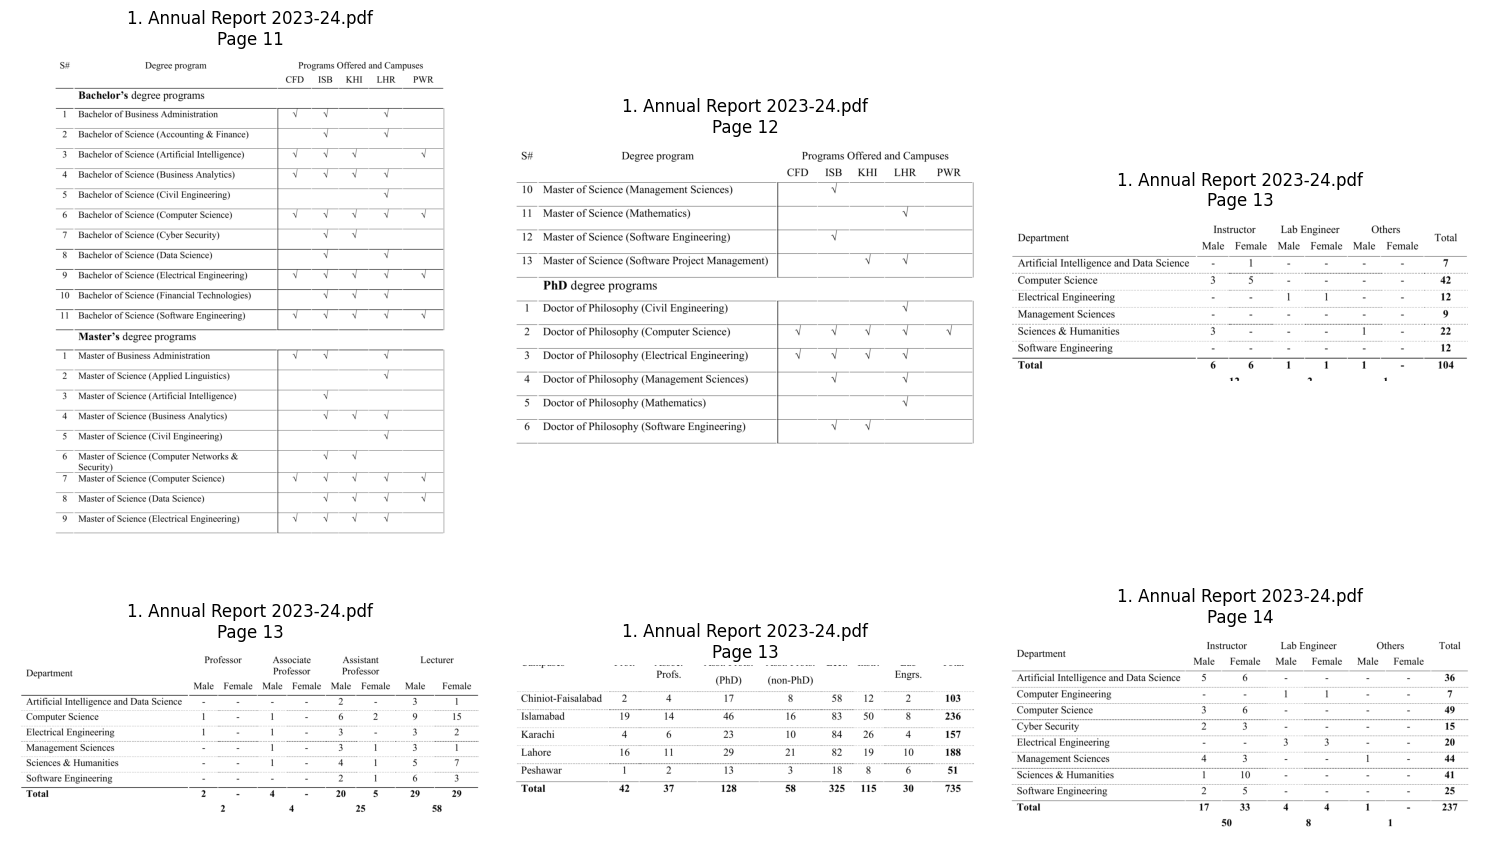

Sample images visualization saved to: extracted_data\sample_images.png


In [36]:
import matplotlib.pyplot as plt

# Display first few extracted images
num_images_to_show = min(6, len(all_image_chunks))

if num_images_to_show > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(num_images_to_show):
        if i < len(all_image_chunks):
            img_path = all_image_chunks[i]['image_path']
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{all_image_chunks[i]['source_file']}\nPage {all_image_chunks[i]['page_number']}")
            axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(num_images_to_show, 6):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FOLDER, 'sample_images.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Sample images visualization saved to: {os.path.join(OUTPUT_FOLDER, 'sample_images.png')}")
else:
    print("No images to display")
